## Costs

**link to the data:**
https://web.archive.org/web/20161019192412/http://lisp.vse.cz/pkdd99/berka.htm

In [1]:
# Load our own functions
%load_ext autoreload
%autoreload 2
from utils.plots import *
from utils.outlier import *
from utils.partitions import *
from utils.complete_missing_dates import *
from utils.df_transformations import *

# import necesary libraries
import os
import sys

#pyspark libraries
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.functions import col , column, lit
from pyspark.sql.functions import to_date
from pyspark.sql.functions import year, month, dayofmonth
import pyspark.sql.functions as sf
from functools import reduce

#plot libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#other
import datetime
import pandas as pd
import numpy as np

# Configuration properties of Apache Spark
APP_NAME = 'pyspark_python'
MASTER = 'local[*]'

conf = SparkConf().setAppName(APP_NAME)
conf = conf.setMaster(MASTER)
spark = SparkSession.builder.config(conf = conf).getOrCreate()
sc = spark.sparkContext

## **Total costs = fixed + variable**

In [2]:
# montly cost
modelDataFile = "Data_ignore/ex1/df_costs.csv"

df_income_g_1 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .option("delimiter", ",") \
  .load(modelDataFile)

modelDataFile = "Data_ignore/ex2/df_costs.csv"

df_income_g_2 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .option("delimiter", ",") \
  .load(modelDataFile)


dfs = [df_income_g_1, df_income_g_2]
df_income_g = reduce(DataFrame.union, dfs)
df_income_g = (df_income_g.drop('_c0', 'g_country_id', 'gf_entity_id')
               .withColumn('account_seniority_y', col('account_seniority_m')/12).sort('gf_customer_id', 'monthly_partition'))

#load outliers
modelDataFile = "Data_ignore/ex1/d_outliers_costs.csv"
d_outliers_income_1 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .option("delimiter", ",") \
  .load(modelDataFile)


modelDataFile = "Data_ignore/ex2/d_outliers_costs.csv"
d_outliers_income_2 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .option("delimiter", ",") \
  .load(modelDataFile)

dfs = [d_outliers_income_1, d_outliers_income_2]
d_outliers_income = reduce(DataFrame.union, dfs)
d_outliers_income = d_outliers_income.drop('_c0', 'g_country_id', 'gf_entity_id').sort('gf_customer_id', 'monthly_partition')

In [21]:
d_outliers = find_outliers(df_income_g.withColumn('year', year('monthly_partition')).withColumn('montly_amount', (-1)*col('montly_amount')), 
                           comparison_column = 'gf_customer_id', 
                           field_value = 'montly_amount',
                          keep_columns = ['monthly_partition']).sort('monthly_partition')
print('number of outliers: ', d_outliers.count())
d_outliers.drop('year').sort('gf_customer_id').show(20, False)

['montly_amount', 'mean', 'stddev', 'skewness', 'median', 'UpperLimit', 'LowerLimit', 'ratio_mean_var', 'Galton']
number of outliers:  10
+--------------+-------------+----------+---------+--------+---------+----------+-----------+---------+--------------+------+
|gf_customer_id|montly_amount|mean      |stddev   |skewness|median   |UpperLimit|LowerLimit |isOutlier|ratio_mean_var|Galton|
+--------------+-------------+----------+---------+--------+---------+----------+-----------+---------+--------------+------+
|65            |-6876.5      |-1969.582 |1548.512 |-1.9    |-1635.68 |2675.953  |-6615.118  |true     |-1217.461     |-0.216|
|588           |-31496.89    |-3768.359 |6148.221 |-4.248  |-2301.59 |14676.302 |-22213.021 |true     |-10031.054    |-0.239|
|651           |-208000.0    |-20577.064|62172.331|-2.844  |-1050.6  |165939.93 |-207094.058|true     |-187849.873   |-0.314|
|898           |-264916.05   |-16327.21 |54985.733|-4.287  |-2030.01 |148629.989|-181284.409|true     |-18

In [17]:
# a lot of seniorities with nulls
d_outliers_income.select('gf_customer_id', 'account_seniority_m').show(20, False)

+--------------+-------------------+
|gf_customer_id|account_seniority_m|
+--------------+-------------------+
|65            |66.0               |
|588           |115.0              |
|651           |null               |
|898           |78.0               |
|1620          |479.0              |
|2086          |null               |
|2086          |null               |
|14138         |null               |
|45634         |195.0              |
|48334         |49.0               |
+--------------+-------------------+



In [6]:
df_income_g.groupby('gf_customer_id').count().show()

+--------------+-----+
|gf_customer_id|count|
+--------------+-----+
|         45634|   23|
|            65|   23|
|           588|   23|
|           898|   23|
|         48334|   23|
|         69933|   18|
|          1620|   23|
|          6726|   23|
|           651|   11|
|         14138|   23|
|         43883|   23|
|          2086|   23|
+--------------+-----+



## **Plot series**

## **Examples pick 2021**

## Caso 1: 

In [7]:
id_values = '65'

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|            65|       2019-05-01|       2828.2|2019|    5|               66.0|                5.5|
|            65|       2019-06-01|      1912.67|2019|    6|               66.0|                5.5|
|            65|       2019-07-01|        862.2|2019|    7|               66.0|                5.5|
|            65|       2019-08-01|       491.78|2019|    8|               66.0|                5.5|
|            65|       2019-09-01|      2405.57|2019|    9|               66.0|                5.5|
|            65|       2019-10-01|      1642.33|2019|   10|               66.0|                5.5|
|            65|       2019-11-01|      1986.36|2019|   11|               66.0|                5.5|


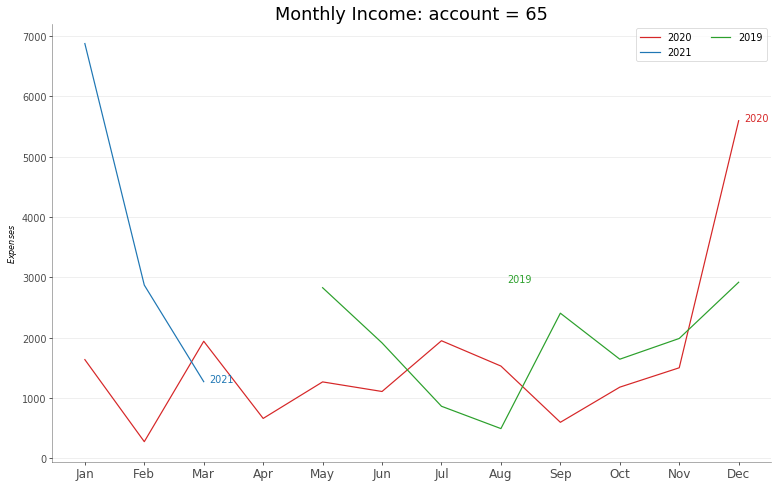

In [8]:
df_income_g.filter(col('gf_customer_id') == id_values).withColumn("monthly_partition", to_date('monthly_partition').cast("string")).show()
d_outliers_income.filter(col('gf_customer_id') == id_values).withColumn("monthly_partition", to_date('monthly_partition').cast("string")).show()

#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Costs: account = " + id_values
ytitle = '$Expenses$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

## Caso 2: 

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|           588|       2019-05-01|      2343.37|2019|    5|              115.0|  9.583333333333334|
|           588|       2019-06-01|      2442.86|2019|    6|              115.0|  9.583333333333334|
|           588|       2019-07-01|       3865.0|2019|    7|              115.0|  9.583333333333334|
|           588|       2019-08-01|      2097.78|2019|    8|              115.0|  9.583333333333334|
|           588|       2019-09-01|      1943.95|2019|    9|              115.0|  9.583333333333334|
|           588|       2019-10-01|      3517.01|2019|   10|              115.0|  9.583333333333334|
|           588|       2019-11-01|      1497.35|2019|   11|              115.0|  9.583333333333334|


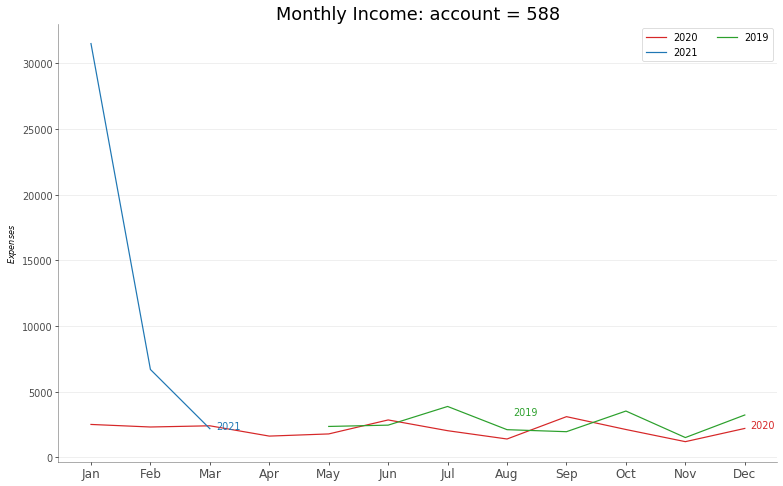

In [9]:
id_values = '588'
df_income_g.filter(col('gf_customer_id') == id_values).withColumn("monthly_partition", to_date('monthly_partition').cast("string")).show()
d_outliers_income.filter(col('gf_customer_id') == id_values).withColumn("monthly_partition", to_date('monthly_partition').cast("string")).show()

#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Costs: account = " + id_values
ytitle = '$Expenses$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

## Caso 3: 

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|           898|       2019-05-01|     12026.22|2019|    5|               78.0|                6.5|
|           898|       2019-06-01|      1843.13|2019|    6|               78.0|                6.5|
|           898|       2019-07-01|        300.0|2019|    7|               78.0|                6.5|
|           898|       2019-08-01|       1200.0|2019|    8|               78.0|                6.5|
|           898|       2019-09-01|     46034.23|2019|    9|               78.0|                6.5|
|           898|       2019-10-01|      4985.41|2019|   10|               78.0|                6.5|
|           898|       2019-11-01|      1632.93|2019|   11|               78.0|                6.5|


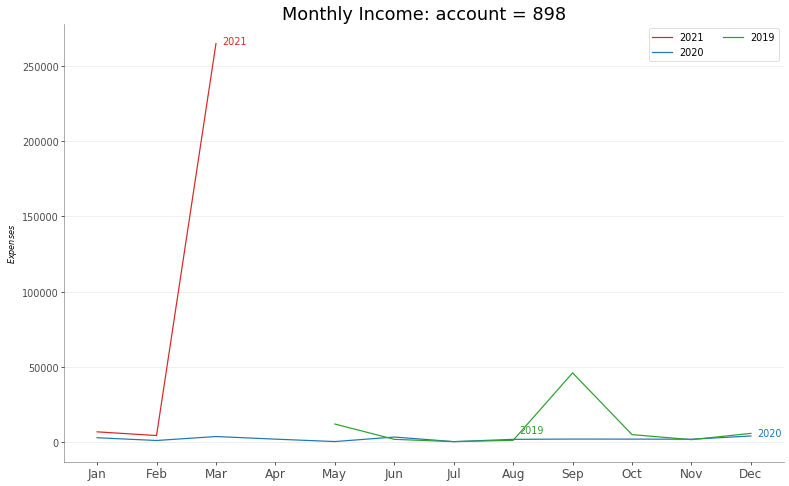

In [10]:
id_values = '898'
df_income_g.filter(col('gf_customer_id') == id_values).withColumn("monthly_partition", to_date('monthly_partition').cast("string")).show()
d_outliers_income.filter(col('gf_customer_id') == id_values).withColumn("monthly_partition", to_date('monthly_partition').cast("string")).show()

#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Costs: account = " + id_values
ytitle = '$Expenses$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

## Caso 4: 

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|           651|       2019-09-01|        920.0|2019|    9|               null|               null|
|           651|       2019-11-01|       1950.0|2019|   11|               null|               null|
|           651|       2019-12-01|       3900.0|2019|   12|               null|               null|
|           651|       2020-01-01|       980.05|2020|    1|               null|               null|
|           651|       2020-05-01|        950.0|2020|    5|               null|               null|
|           651|       2020-08-01|        950.0|2020|    8|               null|               null|
|           651|       2020-10-01|        950.0|2020|   10|               null|               null|


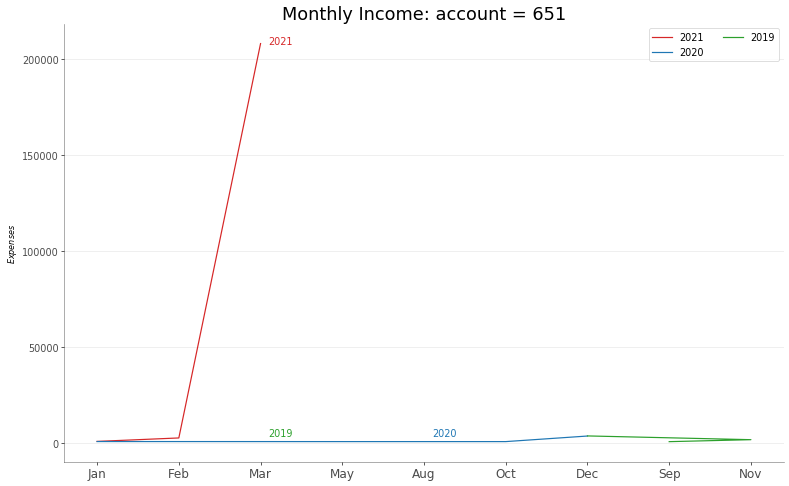

In [11]:
id_values = '651'
df_income_g.filter(col('gf_customer_id') == id_values).withColumn("monthly_partition", to_date('monthly_partition').cast("string")).show()
d_outliers_income.filter(col('gf_customer_id') == id_values).withColumn("monthly_partition", to_date('monthly_partition').cast("string")).show()

#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Costs: account = " + id_values
ytitle = '$Expenses$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|          2086|       2019-05-01|       118.98|2019|    5|               null|               null|
|          2086|       2019-06-01|        55.46|2019|    6|               null|               null|
|          2086|       2019-07-01|      2503.44|2019|    7|               null|               null|
|          2086|       2019-08-01|       2155.0|2019|    8|               null|               null|
|          2086|       2019-09-01|         91.4|2019|    9|               null|               null|
|          2086|       2019-10-01|       202.86|2019|   10|               null|               null|
|          2086|       2019-11-01|       365.02|2019|   11|               null|               null|


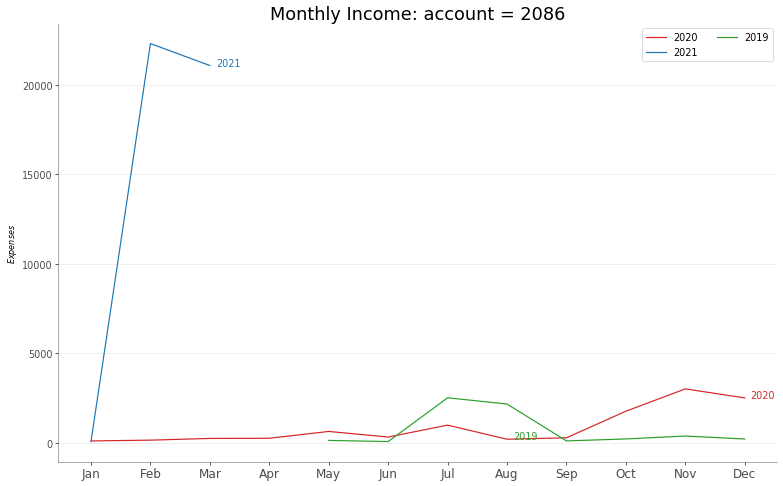

In [12]:
id_values = '2086'
df_income_g.filter(col('gf_customer_id') == id_values).withColumn("monthly_partition", to_date('monthly_partition').cast("string")).show()
d_outliers_income.filter(col('gf_customer_id') == id_values).withColumn("monthly_partition", to_date('monthly_partition').cast("string")).show()

#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Costs: account = " + id_values
ytitle = '$Expenses$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

## Examples 2020

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|         45634|       2019-05-01|      3186.29|2019|    5|              195.0|              16.25|
|         45634|       2019-06-01|      3519.41|2019|    6|              195.0|              16.25|
|         45634|       2019-07-01|      3857.44|2019|    7|              195.0|              16.25|
|         45634|       2019-08-01|      2008.75|2019|    8|              195.0|              16.25|
|         45634|       2019-09-01|      3442.33|2019|    9|              195.0|              16.25|
|         45634|       2019-10-01|      3013.53|2019|   10|              195.0|              16.25|
|         45634|       2019-11-01|       2726.7|2019|   11|              195.0|              16.25|


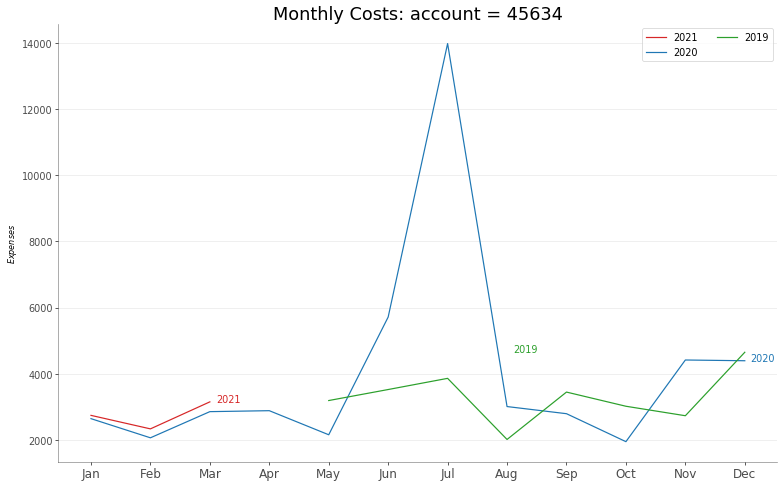

In [31]:
id_values = '45634'
df_income_g.filter(col('gf_customer_id') == id_values).withColumn("monthly_partition", to_date('monthly_partition').cast("string")).show()
d_outliers_income.filter(col('gf_customer_id') == id_values).withColumn("monthly_partition", to_date('monthly_partition').cast("string")).show()

#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Costs: account = " + id_values
ytitle = '$Expenses$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

## **Smoothing**

In [13]:
df_join = (df_income_g.join(d_outliers_income.drop('year', 'month')
                  .select('gf_customer_id','monthly_partition', 'montly_amount', "isOutlier", 'UpperLimit', 'LowerLimit'), ['gf_customer_id','monthly_partition', 'montly_amount'], 'left')
          .withColumn('isOutlier', sf.when(col('isOutlier') == True, 1).otherwise(0)) )
df_join.show(20, False)

+--------------+-------------------+-------------+----+-----+-------------------+-------------------+---------+----------+----------+
|gf_customer_id|monthly_partition  |montly_amount|year|month|account_seniority_m|account_seniority_y|isOutlier|UpperLimit|LowerLimit|
+--------------+-------------------+-------------+----+-----+-------------------+-------------------+---------+----------+----------+
|65            |2019-05-01 00:00:00|2828.2       |2019|5    |66.0               |5.5                |0        |null      |null      |
|65            |2019-06-01 00:00:00|1912.67      |2019|6    |66.0               |5.5                |0        |null      |null      |
|65            |2019-07-01 00:00:00|862.2        |2019|7    |66.0               |5.5                |0        |null      |null      |
|65            |2019-08-01 00:00:00|491.78       |2019|8    |66.0               |5.5                |0        |null      |null      |
|65            |2019-09-01 00:00:00|2405.57      |2019|9    |6

In [14]:
from pyspark.sql.window import Window
from pyspark.sql.functions import *
import numpy as np 
from pyspark.sql.types import FloatType


def rolling_metric(df, partitioned_by = "gf_customer_id", value = "montly_expense", date_field = "monthly_partition", window_size = 3):
    """
    Rolling Median & Mean 
    """
    
    median_udf = udf(lambda x: float(np.median(x)), FloatType())

    w = Window.partitionBy(partitioned_by).orderBy(date_field)
    df = df.withColumn("date", col(date_field).cast("date"))
    df = df.withColumn('rank', F.dense_rank().over(w))
    w2 = (Window().partitionBy(partitioned_by).orderBy("rank").rangeBetween(-window_size, -1)) #excluding the current month, only past values.
    df = df.select("*", (F.mean(value).over(w2)).alias("rolling_avg_" + str(window_size) + "m"))\
            #.filter(col('isOutlier')*col("rank")>=1)
    w2 = (Window().partitionBy(partitioned_by).orderBy("rank").rangeBetween(-(window_size - 1), 0))
    df = df.withColumn("list", collect_list(value).over(w2)) \
      .withColumn("rolling_median_" + str(window_size) + "m", median_udf("list").cast('double')).drop('date', 'rank') #'list', 
    
    return df

def rolling_metric_12m(df, partitioned_by = "gf_customer_id", value = "montly_expense", date_field = "monthly_partition"):
    """
    Rolling Mean of 12 months including the current one.
    """
    window_size = 12

    w = Window.partitionBy(partitioned_by).orderBy(date_field)
    df = df.withColumn("date", col(date_field).cast("date"))
    df = df.withColumn('rank', F.dense_rank().over(w))
    w2 = (Window().partitionBy(partitioned_by).orderBy("rank").rangeBetween(-window_size, 0)) #including the current month, only past values.
    df = (df.select("*", (F.mean(value).over(w2)).alias(value + "_avg_" + str(window_size) + "m"))
          .withColumn(value + "_avg_" + str(window_size) + "m",sf.when(col("rank")>=window_size, col(value + "_avg_" + str(window_size) + "m")).otherwise(0) ))
    
    return df

In [15]:
df_rolling = (rolling_metric(df_join, partitioned_by = "gf_customer_id", value = "montly_amount", date_field = "monthly_partition", window_size = 3))
(df_rolling.drop('mean', 'stddev', 'UpperLimit','LowerLimit').filter(col('gf_customer_id') == id_values).sort('monthly_partition').show(20, False))

+--------------+-------------------+-------------+----+-----+-------------------+-------------------+---------+------------------+---------------------------+------------------+
|gf_customer_id|monthly_partition  |montly_amount|year|month|account_seniority_m|account_seniority_y|isOutlier|rolling_avg_3m    |list                       |rolling_median_3m |
+--------------+-------------------+-------------+----+-----+-------------------+-------------------+---------+------------------+---------------------------+------------------+
|2086          |2019-05-01 00:00:00|118.98       |2019|5    |null               |null               |0        |null              |[118.98]                   |118.9800033569336 |
|2086          |2019-06-01 00:00:00|55.46        |2019|6    |null               |null               |0        |118.98            |[118.98, 55.46]            |87.22000122070312 |
|2086          |2019-07-01 00:00:00|2503.44      |2019|7    |null               |null               |0        

In [16]:
#sustitute 
df_rolling = (df_rolling.withColumn('inc_mean', sf.when(col('isOutlier')== 1, col('rolling_avg_3m')).otherwise(col('montly_amount')))
                        .withColumn('inc_median', sf.when(col('isOutlier')== 1, col('rolling_median_3m')).otherwise(col('montly_amount')))
                                    .drop('rolling_avg_3m', 'list', 'rolling_median_3m', 'account_seniority_m', 'account_seniority_y', 'year', 'month'))
df_rolling.filter(col('gf_customer_id') == id_values).sort('monthly_partition').show(20, False)

+--------------+-------------------+-------------+---------+----------+----------+--------+----------+
|gf_customer_id|monthly_partition  |montly_amount|isOutlier|UpperLimit|LowerLimit|inc_mean|inc_median|
+--------------+-------------------+-------------+---------+----------+----------+--------+----------+
|2086          |2019-05-01 00:00:00|118.98       |0        |null      |null      |118.98  |118.98    |
|2086          |2019-06-01 00:00:00|55.46        |0        |null      |null      |55.46   |55.46     |
|2086          |2019-07-01 00:00:00|2503.44      |0        |null      |null      |2503.44 |2503.44   |
|2086          |2019-08-01 00:00:00|2155.0       |0        |null      |null      |2155.0  |2155.0    |
|2086          |2019-09-01 00:00:00|91.4         |0        |null      |null      |91.4    |91.4      |
|2086          |2019-10-01 00:00:00|202.86       |0        |null      |null      |202.86  |202.86    |
|2086          |2019-11-01 00:00:00|365.02       |0        |null      |nu

In [17]:
df_comparison = rolling_metric_12m(df_rolling, partitioned_by = "gf_customer_id", value = "montly_amount", date_field = "monthly_partition")
df_comparison = rolling_metric_12m(df_comparison, partitioned_by = "gf_customer_id", value = "inc_mean", date_field = "monthly_partition")
df_comparison = rolling_metric_12m(df_comparison, partitioned_by = "gf_customer_id", value = "inc_median", date_field = "monthly_partition")
df_comparison.drop('UpperLimit', 'LowerLimit', 'inc_mean', 'inc_median').filter(col('gf_customer_id') == id_values).sort('monthly_partition').show(20, False)

+--------------+-------------------+-------------+---------+----------+----+---------------------+------------------+------------------+
|gf_customer_id|monthly_partition  |montly_amount|isOutlier|date      |rank|montly_amount_avg_12m|inc_mean_avg_12m  |inc_median_avg_12m|
+--------------+-------------------+-------------+---------+----------+----+---------------------+------------------+------------------+
|2086          |2019-05-01 00:00:00|118.98       |0        |2019-05-01|1   |0.0                  |0.0               |0.0               |
|2086          |2019-06-01 00:00:00|55.46        |0        |2019-06-01|2   |0.0                  |0.0               |0.0               |
|2086          |2019-07-01 00:00:00|2503.44      |0        |2019-07-01|3   |0.0                  |0.0               |0.0               |
|2086          |2019-08-01 00:00:00|2155.0       |0        |2019-08-01|4   |0.0                  |0.0               |0.0               |
|2086          |2019-09-01 00:00:00|91.4 

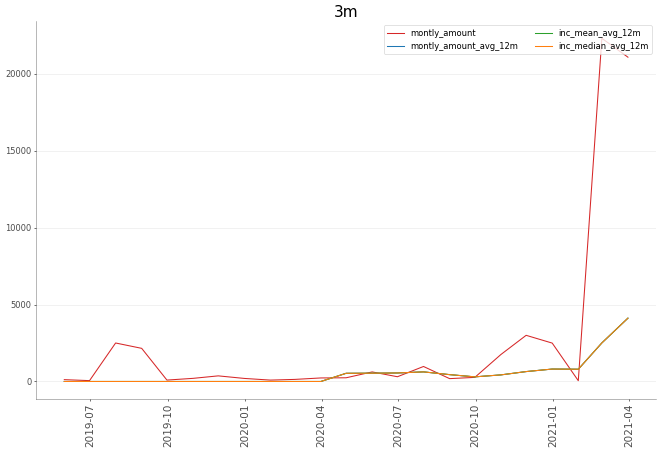

In [18]:
df = (to_explode(df_comparison.select('monthly_partition', 'gf_customer_id', 'montly_amount',  'montly_amount_avg_12m', 
                                      'inc_mean_avg_12m', 'inc_median_avg_12m'), ['monthly_partition', 'gf_customer_id']))
#Montly partition (end of the month): because we aggregate the transactions of the month
df = df.withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd"))
df = df.filter(col('gf_customer_id') == id_values) 
df = df.withColumn("monthly_partition", to_date('monthly_partition')).toPandas() #.cast("string")
plot_different_type_series(df, 'monthly_partition', 'movs', 'field',  title ='3m', ytitle = '', dpi_value = 50, width = 16, height = 10, text_ = False)

In [19]:
df_comparison.drop('UpperLimit', 'LowerLimit', 'inc_mean', 'inc_median').filter('''montly_amount_avg_12m > 0''').sort('gf_customer_id', 'monthly_partition').show(2000, False)

+--------------+-------------------+-------------+---------+----------+----+---------------------+------------------+------------------+
|gf_customer_id|monthly_partition  |montly_amount|isOutlier|date      |rank|montly_amount_avg_12m|inc_mean_avg_12m  |inc_median_avg_12m|
+--------------+-------------------+-------------+---------+----------+----+---------------------+------------------+------------------+
|65            |2020-04-01 00:00:00|660.39       |0        |2020-04-01|12  |1629.955             |1629.955          |1629.955          |
|65            |2020-05-01 00:00:00|1266.09      |0        |2020-05-01|13  |1601.9653846153847   |1601.9653846153847|1601.9653846153847|
|65            |2020-06-01 00:00:00|1107.1       |0        |2020-06-01|14  |1469.573076923077    |1469.573076923077 |1469.573076923077 |
|65            |2020-07-01 00:00:00|1948.64      |0        |2020-07-01|15  |1472.34              |1472.34           |1472.34           |
|65            |2020-08-01 00:00:00|1528.

In [ ]:
#erase ...

## **Income**

- If we have a expense that is due to an increase in income ¿is it a pick?
- We can have the case of persons that does not have severla incomes, these are not equal. 

In [ ]:
df = to_explode(df_complet_year.select('monthly_partition', 'gf_customer_id', 'montly_expense', 'montly_income'), ['monthly_partition', 'gf_customer_id'])
df = df.filter(col('gf_customer_id') == id_values).toPandas()
df_roll = df_rolling.filter(col('gf_customer_id') == id_values).toPandas()
plot_different_type_series_wit_limits(df, df_roll, 'monthly_partition', 'movs','field', 'UpperLimit', 'LowerLimit', title ='2m', ytitle = '',  dpi_value = 58, width = 20, height = 10)

In [ ]:
import math 
df_complet_year_proy = (df_complet_year.select('gf_customer_id', 'montly_income', 'montly_expense')
 .withColumn('proyection', col('montly_expense')*math.cos(45)))

title = "Income vs expending"
x_label = 'Montly Expense' 
y_label = 'Montly Income'
x_field = 'montly_expense'
y_field = 'montly_income' 


df = df_complet_year.filter(col('gf_customer_id') == id_values).toPandas()
scatter_plot(df, x_field, y_field, title, x_label, y_label, dpi =40 )

In [ ]:
#transform data to pandas
df = df_complet_year.filter(col('gf_customer_id') == id_values).sort('month').toPandas()
# plot
title = "Monthly Costs: account = " + id_values
ytitle = '$Income$'
date_name = 'monthly_partition'
yaxis_field = 'montly_income'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

## **Change detection**

https://github.com/BMClab/BMC/blob/master/notebooks/DetectCUSUM.ipynb

In [ ]:
df_group.show(2, False)

In [ ]:
#just for now but we need to complete the data

df_group_2 = df_group.sort('account_id', 'monthly_partition').filter(col('account_id') == id_values)

In [ ]:
from pyspark.sql.functions import lag
from pyspark.sql.window import Window
df_group_2 = df_group_2.withColumn('sum_amount_lag', lag('sum_amount').over(
            Window.partitionBy('account_id').orderBy('monthly_partition')))

In [ ]:
df_group_2.sort('account_id', 'monthly_partition').show(5, False)

In [ ]:
df_group_2 = df_group_2.withColumn('s_pos', col('sum_amount_lag') - col('sum_amount')).withColumn('cumsum', sf.sum('s_pos').over(Window.partitionBy('account_id').orderBy('monthly_partition')))
df_group_2 = df_group_2.withColumn('s_neg', - col('sum_amount_lag') + col('sum_amount')).withColumn('cumsum', sf.sum('s_neg').over(Window.partitionBy('account_id').orderBy('monthly_partition')))
df_group_2 = df_group_2.withColumn('g_neg', sf.when(col('s_neg')> 0, col('s_neg')).otherwise(0))
df_group_2 = df_group_2.withColumn('g_pos', sf.when(col('s_pos')> 0, col('s_pos')).otherwise(0))
df_group_2.show(20, False)                                                                                  

In [ ]:
df_g = df_group_2.toPandas()
plt.plot(df_g['monthly_partition'], df_g['g_neg'], c = 'b', label = 'g_neg')
plt.plot(df_g['monthly_partition'], df_g['g_pos'], c = 'r', label = 'g_pos')
#plt.plot(mean, c = 'r', label = 'Exponentially Weighted Moving Average')
#plt.plot(mean_plus_std, 'k--', label = 'Prediction Bounds')
#plt.plot(mean_minus_std, 'k--')
#plt.scatter(outliers.index, outliers['Users'], c = 'r', marker = 'o', s = 120, label = 'Outliers')
plt.legend()

## References
- [AN ADJUSTED BOXPLOT FOR SKEWED DISTRIBUTIONS](https://wis.kuleuven.be/stat/robust/papers/2004/boxplotCOMPSTAT04.pdf)
- [Top 50 matplotlib Visualizations](https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/)
- Explaining Anomalies in Groups with Characterizing Subspace Rules(https://www.andrew.cmu.edu/user/lakoglu/pubs/18-pkdd-journal-xpacs.pdf)
- anomaly-detection-resources(https://github.com/yzhao062/anomaly-detection-resources#31-multivariate-data)
- https://github.com/BMClab/BMC

In [ ]:
#https://github.com/HamishWoodrow/anomaly_detection/blob/master/anom_detect.py
def plot(self,data_label=None,left=None,right=None,bottom=None,top=None):
        '''Anomalous datapoint plotting method
        This can be used to plot a visualisation of the data with the moving
        average, standard deviations and the anomalous data points marked.
        Parameters
        ----------
        data_label : str
            Raw data series name, to be displayed on y-axis and legend.
        left : int
            xlimit for left limit of plot x-axis
        right : int
            xlimit for right limit of plot x-axis
        bottom : int
            ylimit for bottom limit of plot y-axis
        top : int
            ylimit for top limit of plot y-axis
        '''
        df = self.results
        anoma_points = self.anoma_points
        fig, ax1 = plt.subplots(1, 1,figsize=(15, 8))
        ax1.plot(list(df.index),df.iloc[:,0],'b.',label=data_label)
        ax1.plot(list(df.index),df.mean_count,'r',label='Moving Average')
        ax1.fill_between(df.index,df.pos_std,df.neg_std,color='red',alpha=0.3,label='1Sigma')
        ax1.fill_between(df.index,df.pos_std_2,df.neg_std_2,color='red',alpha=0.1,label='2Sigma')
        ax1.plot(list(anoma_points.index),anoma_points.iloc[:,0],'r*',label='Anomalous Points')
        ax1.set_xlabel('time')
        ax1.set_ylabel(data_label)
        ax1.set_title('Data with Anomalies starred')
        ax1.set_xlim(left=left,right=right)
        ax1.set_ylim(bottom=bottom,top=top)
        ax1.legend();

In [ ]:
#Using Exponentially Weighted Moving Average for anomaly detection
#https://www.mikulskibartosz.name/using-exponentially-weighted-moving-average-for-anomaly-detection/

import pandas as pd
import matplotlib.pyplot as plt

window_size = 3
mean = work_days['Users'].ewm(window_size).mean()
std = work_days['Users'].ewm(window_size).std()
std[0] = 0 #the first value turns into NaN because of no data

mean_plus_std = mean + std
mean_minus_std = mean - std

is_outlier = (work_days['Users'] > mean_plus_std) | (work_days['Users'] < mean_minus_std)
outliers = work_days[is_outlier]

plt.plot(work_days['Users'], c = 'b', label = 'Actual Values')
plt.plot(mean, c = 'r', label = 'Exponentially Weighted Moving Average')
plt.plot(mean_plus_std, 'k--', label = 'Prediction Bounds')
plt.plot(mean_minus_std, 'k--')
plt.scatter(outliers.index, outliers['Users'], c = 'r', marker = 'o', s = 120, label = 'Outliers')
plt.legend()

In [ ]:
#Weighted moving average in Pyspark
#https://stackoverflow.com/questions/47622447/weighted-moving-average-in-pyspark
from pyspark.sql.functions import coalesce, lit, col, lead, lag
from operator import add
from functools import reduce

def weighted_average(c, window, offsets, weights):
    assert len(weights) == len(offsets)

    def value(i):
        if i < 0: return lag(c, -i).over(window)
        if i > 0: return lead(c, i).over(window)
        return c

    # Create a list of Columns
    # - `value_i * weight_i` if `value_i IS NOT NULL` 
    # - literal 0 otherwise
    values = [coalesce(value(i) * w, lit(0)) for i, w in zip(offsets, weights)]

    # or sum(values, lit(0))
    return reduce(add, values, lit(0))


from pyspark.sql.window import Window

df = spark.createDataFrame([
    ("a", 1, 1.4), ("a", 2, 8.0), ("a", 3, -1.0), ("a", 4, 2.4),
    ("a", 5, 99.0), ("a", 6, 3.0), ("a", 7, -1.0), ("a", 8, 0.0)
]).toDF("id", "time", "value")

w = Window.partitionBy("id").orderBy("time")
offsets, delays =  [-2, -1, 0, 1, 2], [0.1, 0.20, 0.4, 0.20, 0.1]

result = df.withColumn("avg", weighted_average(
    col("value"), w, offsets, delays
))
result.show()


In [ ]:
#The Exponential Moving Average (EMA), the Exponential Moving Standard Deviation (EDS)
#https://machinelearnings.co/data-science-tricks-simple-anomaly-detection-for-metrics-with-a-weekly-pattern-2e236970d77#.cij9voloi
##https://stackoverflow.com/questions/33959294/apache-spark-exponential-moving-average   
    
my_window = Window.orderBy("timestamp")

df.withColumn("price_lag_1",when(lag(col("price"),1).over(my_window).isNull,lit(0)).otherwise(lag(col("price"),1).over(my_window)))

df.withColumn("ema_price", 
price * lit(0.4) * Math.pow(0.6,0) + 
lag(col("price"),1).over(my_window) * 0.4 * Math.pow(0.6,1) +
lag(col("price"),2).over(my_window) * 0.4 * Math.pow(0.6,2)  + .... )

def emaFunc (y: org.apache.spark.sql.Column, group: org.apache.spark.sql.Column, order: org.apache.spark.sql.Column, beta: Double, lookBack: Int) : org.apache.spark.sql.Column = {
  val ema_window = Window.partitionBy(group).orderBy(order)
  var i = 1
  var result = y
  while (i < lookBack){
    result =  result + lit(1) * ( when(lag(y,i).over(ema_window).isNull,lit(0)).otherwise(lag(y,i).over(ema_window)) * beta * Math.pow((1-beta),i) 
    - when(lag(y,i).over(ema_window).isNull,lit(0)).otherwise(y * beta * Math.pow((1-beta),i))   )
    i = i + 1
  }
  return result } 

df.withColumn("one",lit(1))
  .withColumn("ema_price", emaFunc('price,'one,'timestamp,0.1,10)
                                   


In [ ]:
Holt-Winter ETS
https://medium.com/@tle3006/single-seasonal-time-series-anomaly-detection-with-brutlags-algorithm-and-holt-winter-ets-d8aea1fd1bfc

https://datascience.aero/anomaly-detection/
- Change detectors based on z-scores: Z-Score measures the distance from the population mean in units of the standard error. It can be used to identify when a sample is deviating from the expected statistic of the population. One common approach is to maintain two sets of statistics (e.g. mean and std) that describe the signal and compare them using z-score.
- Cumulative sum control chart (CUSUM): It iteratively calculates the weighted cumulative sum. When this sum exceeds a certain threshold value, a change value has been found. It is a valuable “online” methodology with plenty of use in streaming change detection. There are plenty of available implementations of this algorithm.
- Bayesian detection: This method is based on the prior train of thought on how probable is it to have two successive change-points with certain distance. Then, it models the likelihood of the data in the sequence given that there is no change-point in the sequence. This methodology works well but can be slow depending on the length of the time series. There are plenty of implementations in both Python and R.
- Cost sensitive methods

- (Instance-Dependent Cost-Sensitive Learning for Detecting Transfer Fraud)[https://arxiv.org/abs/2005.02488#:~:text=Instance%2DDependent%20Cost%2DSensitive%20Learning%20for%20Detecting%20Transfer%20Fraud,-Sebastiaan%20H%C3%B6ppner%2C%20Bart&text=Fraud%20detection%20is%20to%20be,for%20learning%20a%20classification%20model.]

# Cluster Identication Using Projections

Code of the paper: 

Peña, D., & Prieto, F. J. (2011). Cluster identification using projections. Journal of the American Statistical Association.

#Link:
http://halweb.uc3m.es/esp/Personal/personas/dpena/publications/ingles/2001JASA_prieto.pdf

Mirroring from: http://halweb.uc3m.es/fjp/download.html

https://e-archivo.uc3m.es/bitstream/handle/10016/15524/cluster_prieto_JASA_2001_ps.pdf?sequence=1

In [ ]:
# proy 
https://www.dropbox.com/s/jkpg18n6xnwcie2/proy.txt?dl=0

In [ ]:

https://datascienceplus.com/robust-regressions-dealing-with-outliers-in-r/
https://anomaly.io/anomaly-detection-normal-distribution/
https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561

 


Code in R to check outliers

%%R -i xx -w 500 -h 400 -u px
dt = as.data.frame(xx)
names(dt) <- c('importe')
#outlierKD(dt, 'importe') 
var = 'importe'
#
var_name <- dt$importe #eval(substitute(var),eval(dt))

# own functions 

na1 <- sum(is.na(var_name))
m1 <- mean(var_name, na.rm = T)
par(mfrow=c(2, 3), oma=c(0,0,3,0))
boxplot(var_name, main="With outliers")
hist(var_name, main="With outliers", xlab=NA, ylab=NA)
outlier <- boxplot.stats(var_name)$out
mo <- mean(outlier)
qqnorm(var_name)
qqline(var_name)

var_name <- ifelse(var_name %in% outlier, NA, var_name)
boxplot(var_name, main="Without outliers")
hist(var_name, main="Without outliers", xlab=NA, ylab=NA)
title("Outlier Check", outer=TRUE)
na2 <- sum(is.na(var_name))
cat("Outliers identified:", na2 - na1, "\n")
cat("Propotion (%) of outliers:", round((na2 - na1) / sum(!is.na(var_name))*100, 1), "n")
cat("Mean of the outliers:", round(mo, 2), "\n")
m2 <- mean(var_name, na.rm = T)
cat("Mean without removing outliers:", round(m1, 2), "\n")
cat("Mean if we remove outliers:", round(m2, 2), "\n")

qqnorm(var_name)
qqline(var_name)

    